<a href="https://colab.research.google.com/github/Ayisha-Parveen/Hamoye_Assignments/blob/main/Amazon_Ayisha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# Planet: Understanding the Amazon from Space

Target: Use satellite data to track the human footprint in the Amazon rainforest

Source: https://www.kaggle.com/c/planet-understanding-the-amazon-from-space


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.applications import ResNet50, VGG16
from keras.optimizers import Adam

from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split

import cv2
import os
from tqdm import tqdm

import time

from os import listdir
import csv

In [ ]:
# load csv
df_train = pd.read_csv('C:/Users/ayisha/Downloads/archive/planet/planet/train_classes.csv')
df_train.sample(5)

,image_name,tags
11669,train_11669,agriculture clear primary road
7540,train_7540,agriculture clear cultivation primary water
9199,train_9199,clear primary
32346,train_32346,agriculture clear primary road water
28569,train_28569,clear primary


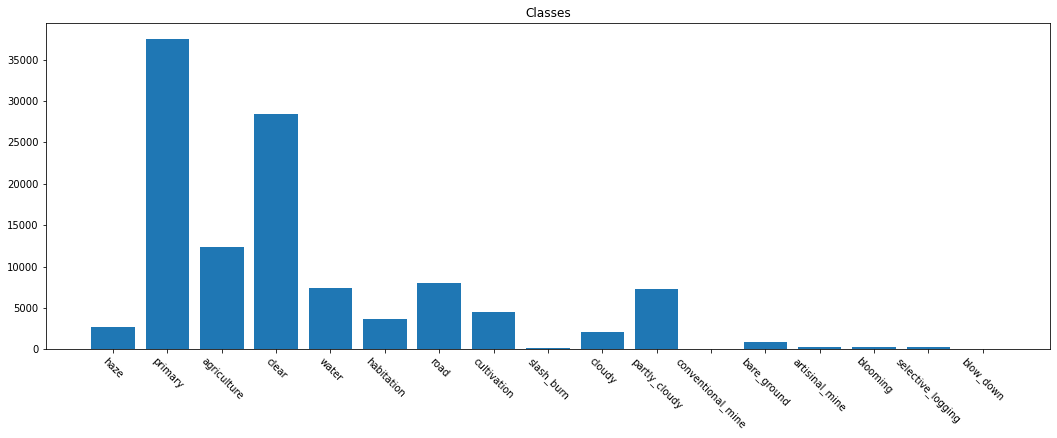

In [ ]:
# numbers of tags and their names
counts = {}
splitted_tags = df_train['tags'].map(lambda x: x.split(' '))
for labels in splitted_tags.values:
    for label in labels:
        counts[label] = counts[label] + 1  if label in counts else 0

plt.figure(figsize=(18, 6))
plt.title('Classes')
idxs = range(len(counts.values()))
plt.xticks(idxs, counts.keys(), rotation=-45)
plt.bar(idxs, counts.values());

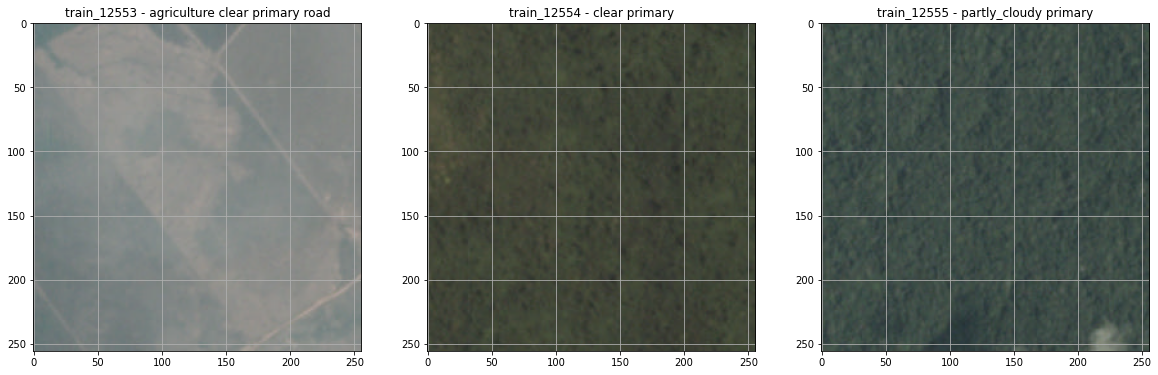

In [ ]:
# random images
plt.rc('axes', grid = True)

_, ax = plt.subplots(1, 3, figsize=(20, 20))
random_img = np.random.randint(0,len(df_train) - 3)
for i , (file, label) in enumerate(df_train[random_img:random_img + 3].values):
    img = cv2.imread('C:/Users/ayisha/Downloads/archive/planet/planet/train-jpg/{}.jpg'.format(file))
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].set_title('{} - {}'.format(file, label))
    
plt.show()

In [ ]:
# load data
all_labels = splitted_tags.values
labels = list(set([y for x in all_labels for y in x]))

def load_data(df_train, labels, resize):
    X_train = []
    y_train = []

    label_map = {l: i for i, l in enumerate(labels)}
    inv_label_map = {i: l for l, i in label_map.items()}

    for f, tags in df_train.values:
        img = cv2.imread('C:/Users/ayisha/Downloads/archive/planet/planet/train-jpg/{}.jpg'.format(f))
        targets = np.zeros(17)
        for t in tags.split(' '):
            targets[label_map[t]] = 1 

        X_train.append(cv2.resize(img,resize))
        y_train.append(targets)
        
    y_train = np.array(y_train, np.uint8)
    X_train = np.array(X_train, np.float16) / 255.

    return X_train, y_train

In [ ]:
X, y = load_data(df_train, labels, resize=(128, 128))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = int(time.time()))

### Learning curve

In [ ]:
def learning_curve(model_fit, key='acc', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

### F beta score - metric

In [ ]:
def fbeta_score_K(y_true, y_pred):
    beta_squared = 4

    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return result

## CNN

In [ ]:
model1 = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.1),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.1),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.1),

    Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.1),

    Flatten(),

    Dense(1024, activation='relu'),
    Dense(17, activation='sigmoid') 
])

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=[fbeta_score_K])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
__________

In [ ]:
model_fit1 = model1.fit(
    X_train, y_train,
    batch_size=128,
    epochs=5,
    verbose=1,
    validation_data=(X_val, y_val)
)

Train on 32383 samples, validate on 8096 samples
Epoch 1/5
32383/32383 [==============================] - 119s 4ms/step - loss: 0.2496 - fbeta_score_K: 0.5807 - val_loss: 0.2232 - val_fbeta_score_K: 0.6222
Epoch 2/5
32383/32383 [==============================] - 108s 3ms/step - loss: 0.1946 - fbeta_score_K: 0.6561 - val_loss: 0.1770 - val_fbeta_score_K: 0.6840
Epoch 3/5
32383/32383 [==============================] - 107s 3ms/step - loss: 0.1735 - fbeta_score_K: 0.6961 - val_loss: 0.1740 - val_fbeta_score_K: 0.7053
Epoch 4/5
32383/32383 [==============================] - 106s 3ms/step - loss: 0.1615 - fbeta_score_K: 0.7181 - val_loss: 0.1597 - val_fbeta_score_K: 0.7174
Epoch 5/5
32383/32383 [==============================] - 106s 3ms/step - loss: 0.1556 - fbeta_score_K: 0.7283 - val_loss: 0.1546 - val_fbeta_score_K: 0.7273


In [ ]:
y_pred = model1.predict(X_val, batch_size=128)
score = fbeta_score(y_val, np.array(y_pred) > 0.2, beta=2, average='samples')

print("F beta score: ", score)
print("Error: %.2f%%" % (100 - score * 100))

F beta score:  0.8506458157912676
Error: 14.94%


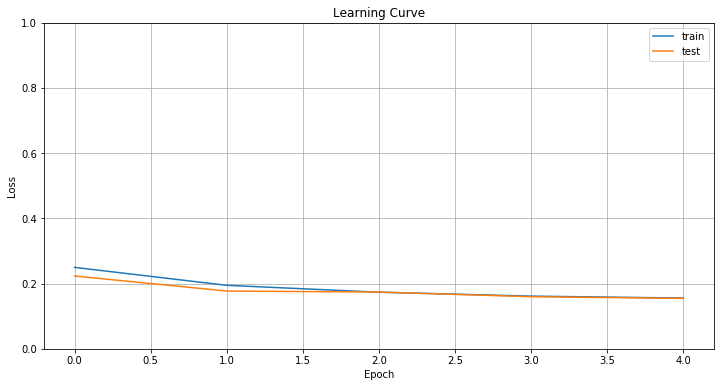

In [ ]:
learning_curve(model_fit1, key='loss', ylim=(0, 1))

# VGG

In [ ]:
optimizer = Adam(0.003, decay=0.0005)
base_model2 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False
    
    model2 = Sequential([
    base_model2,
 
    Flatten(), 
        
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(17, activation='sigmoid')  
])

model2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta_score_K])
model2.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_18 (Flatten)        (None, 8192)              0         
                                                                 
 dense_36 (Dense)            (None, 128)               1048704   
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_37 (Dense)            (None, 17)                2193      
                                                                 
Total params: 15,765,585
Trainable params: 1,050,897
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model_fit2 = model2.fit(
    X_train, y_train,
    batch_size=128,
    epochs=5,
    verbose=1,
    validation_data=(X_val, y_val)
)

Train on 32383 samples, validate on 8096 samples
Epoch 1/5
32383/32383 [==============================] - 147s 5ms/step - loss: 0.1876 - fbeta_score_K: 0.6884 - val_loss: 0.1497 - val_fbeta_score_K: 0.7217
Epoch 2/5
32383/32383 [==============================] - 146s 4ms/step - loss: 0.1503 - fbeta_score_K: 0.7371 - val_loss: 0.1407 - val_fbeta_score_K: 0.7488
Epoch 3/5
32383/32383 [==============================] - 146s 5ms/step - loss: 0.1418 - fbeta_score_K: 0.7523 - val_loss: 0.1362 - val_fbeta_score_K: 0.7632
Epoch 4/5
32383/32383 [==============================] - 146s 5ms/step - loss: 0.1375 - fbeta_score_K: 0.7600 - val_loss: 0.1410 - val_fbeta_score_K: 0.7767
Epoch 5/5
32383/32383 [==============================] - 146s 5ms/step - loss: 0.1336 - fbeta_score_K: 0.7667 - val_loss: 0.1309 - val_fbeta_score_K: 0.7738


In [ ]:
y_pred = model2.predict(X_val, batch_size=128)
score = fbeta_score(y_val, np.array(y_pred) > 0.2, beta=2, average='samples')

print("Test score (f1): ", score)
print("Error: %.2f%%" % (100-score*100))

Test score (f1):  0.8814680564589861
Error: 11.85%


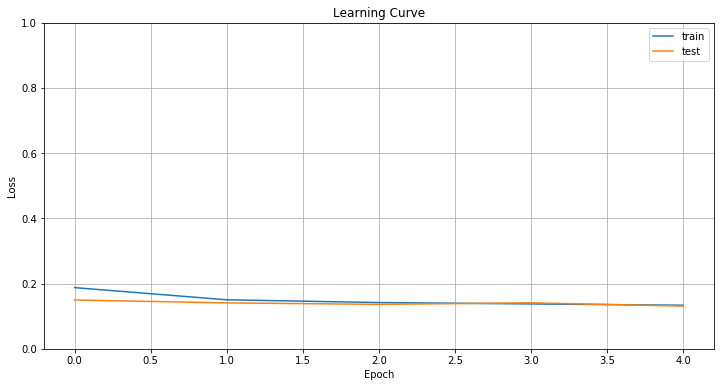

In [ ]:
learning_curve(model_fit2, key='loss', ylim=(0, 1))

In [ ]:
# decrease learning step and decay
optimizer = Adam(0.0001, decay=0.00001)
model2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta_score_K])

model_fit3 = model2.fit(
    X_train, y_train,
    batch_size=128,
    epochs=5,
    verbose=1,
    validation_data=(X_val, y_val))

Epoch 1/5
253/253 [==============================] - 1794s 7s/step - loss: 0.2704 - fbeta_score_K: 0.5891 - val_loss: 0.1957 - val_fbeta_score_K: 0.6414
Epoch 2/5
253/253 [==============================] - 1690s 7s/step - loss: 0.2021 - fbeta_score_K: 0.6593 - val_loss: 0.1744 - val_fbeta_score_K: 0.6827
Epoch 3/5
253/253 [==============================] - 1695s 7s/step - loss: 0.1831 - fbeta_score_K: 0.6863 - val_loss: 0.1650 - val_fbeta_score_K: 0.6929
Epoch 4/5
253/253 [==============================] - 1680s 7s/step - loss: 0.1721 - fbeta_score_K: 0.7021 - val_loss: 0.1581 - val_fbeta_score_K: 0.7164
Epoch 5/5
253/253 [==============================] - 1638s 6s/step - loss: 0.1645 - fbeta_score_K: 0.7131 - val_loss: 0.1533 - val_fbeta_score_K: 0.7237


In [ ]:
y_pred = model2.predict(X_val, batch_size=128)
score = fbeta_score(y_val, np.array(y_pred) > 0.2, beta=2, average='samples')

print("Test score (f1): ", score)
print("Error: %.2f%%" % (100-score*100))

64/64 [==============================] - 319s 5s/step
Test score (f1):  0.8539666673499707
Error: 14.60%


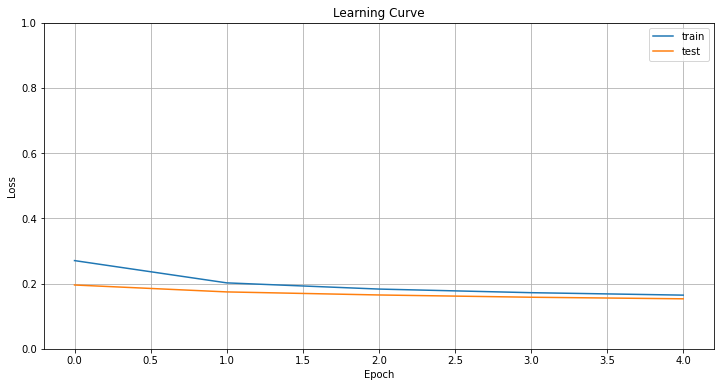

In [ ]:
learning_curve(model_fit3, key='loss', ylim=(0, 1))

In [ ]:
# kaggle submission
X_test = []
submission = []
for file in listdir('C:/Users/ayisha/Downloads/archive/planet/planet/test-jpg'):
    filename = file.split('.')[0]
    
    img = cv2.imread('C:/Users/ayisha/Downloads/archive/planet/planet/test-jpg/{}.jpg'.format(filename))
    targets = np.zeros(17)
    
    X_test.append(cv2.resize(img, (128, 128)))
    submission.append(filename)

X_test = np.array(X_test, np.float16) / 255

y_test = model.predict(X_test, batch_size=128)

with open('output.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(('image_name', 'tags'))
    for i, image in enumerate(submission):
        csv_writer.writerow((image, ' '.join(np.array(labels)[y_test[i] > 0.2])))

479/479 [==============================] - 2523s 5s/step
